
***Я работаю в компании, которая продает б/у машины в Москве. Мне как ведущему специалисту в области Data Science было поручено, создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам.***
<img src='https://lh3.googleusercontent.com/JL_q-h3q8hgzlCJcVz7Hrhh2tMvOtLjZmzKisKwkALuK-wy2CUHWv6WDcm3-e0J8RFrf9r0uWgzIzdXEk8lOIRx8hgULJXzZnFoX1vkV6XpFwkOP4mfLMAoq-tAMZlWm5-_-ojnv9i4'>

# Импорт библиотек

In [1]:
import requests
from bs4 import BeautifulSoup
from scipy.stats import ttest_ind, normaltest
from itertools import combinations
import re
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.model_selection import GridSearchCV
RANDOM_SEED = 42
warnings.filterwarnings('ignore')

In [2]:
# дополнительные функции для анализа данных


def info_kat(data, col):
    print('Количество пропущенных значений:', data[col].isnull().sum())
    print('Количество уникальных значений:', data[col].nunique())
    display(data[col].value_counts())
    sns.countplot(y=col, data=data)


def bin_kat(data, col):
    print('Количество пропущенных значений:', data[col].isnull().sum())
    print('Количество уникальных значений:', data[col].nunique())
    display(data[col].value_counts())
    fig, ax = plt.subplots(1, 2, figsize=(12, 7))
    sns.countplot(x=col, data=data, ax=ax[0])


def num_kat(data, col):
    print('Количество пропущенных значений:', data[col].isnull().sum())
    print('Основная статистика:')
    display(data[col].describe())
    data[col].hist()


# функция для исследония данных на выбросы
def vubros(x):
    median = pd.DataFrame(x).median()[0]
    IQR = pd.DataFrame(x).quantile(0.75)[0] - pd.DataFrame(x).quantile(0.25)[0]
    perc25 = pd.DataFrame(x).quantile(0.25)[0]
    perc75 = pd.DataFrame(x).quantile(0.75)[0]
    df = pd.Series(x).loc[pd.Series(x).between(
        perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
          "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    plt.hist(df, bins=10, range=(0, (perc75 + 1.5*IQR)*1.2), label='IQR')
    plt.legend()


# функция, возвращающая границы для удаления выбросов
def interval_vubros(x):
    median = pd.DataFrame(x).median()[0]
    IQR = pd.DataFrame(x).quantile(0.75)[0] - pd.DataFrame(x).quantile(0.25)[0]
    perc25 = pd.DataFrame(x).quantile(0.25)[0]
    perc75 = pd.DataFrame(x).quantile(0.75)[0]
    f = perc25 - 1.5*IQR
    l = perc75 + 1.5*IQR
    return(f, l)

# Парсинг сайта

Для начала создаем список урлов объявлений.
<p>Исходя из тестовых данных и условия задачи, сделано 3 предпосылки. На основании которых, мы создаем фильтр.</p>
<ul>
<li>Авто с пробегом</li>
<li>Авто продается на территории Москвы и Моск.области</li>
<li>Авто представлены одной маркой - BMW</li>
</ul>

***Все блоки, после выполенния поставленной задачи, с этого раздела отключены, чтобы не мешали в дальнейшей работе с ноутбуком.***

In [3]:
'''# В этом блоке осуществлялся парсинг, отключен, дабы не злоупотреблять доверием и не быть забаненым)))
# Тут был сбор урлов на сами страницы объявлений, с учетом фильтра
data_url = []
for k in range(1, 99):
    url = 'https://auto.ru/moskovskaya_oblast/cars/bmw/used/?page='+str(k)
    response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    # response.encoding='KOI-8R'
    soup = BeautifulSoup(response.text, 'html.parser')
    links = soup.find_all('a', class_='Link ListingItemTitle-module__link')
    for i in range(len(links)):
        if links[i].has_attr('href'):
            data_url.append(links[i]['href'])/'''

"# В этом блоке осуществлялся парсинг, отключен, дабы не злоупотреблять доверием и не быть забаненым)))\n# Тут был сбор урлов на сами страницы объявлений, с учетом фильтра\ndata_url = []\nfor k in range(1, 99):\n    url = 'https://auto.ru/moskovskaya_oblast/cars/bmw/used/?page='+str(k)\n    response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})\n    # response.encoding='KOI-8R'\n    soup = BeautifulSoup(response.text, 'html.parser')\n    links = soup.find_all('a', class_='Link ListingItemTitle-module__link')\n    for i in range(len(links)):\n        if links[i].has_attr('href'):\n            data_url.append(links[i]['href'])/"

In [4]:
'''# Сохранение списка линков на объявления в файл, чтобы не парсить снова сайт.
series_url = pd.Series(data_url)
series_url.to_csv('data_url.csv')
print(len(data_url))'''

"# Сохранение списка линков на объявления в файл, чтобы не парсить снова сайт.\nseries_url = pd.Series(data_url)\nseries_url.to_csv('data_url.csv')\nprint(len(data_url))"

In [5]:
'''# Cоздаем DataFrame, в который будут записываться данных
df = pd.DataFrame(columns=['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name', 'numberOfDoors', 'productionDate',
                           'vehicleConfiguration', 'vehicleTransmission', 'engineDisplacement', 'enginePower',
                           'description', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Состояние', 'Владельцы',
                           'ПТС', 'Таможня', 'Владение', 'price'])
k = 0
links = pd.read_csv('data_url.csv')
print(links.iloc[:, 1].tolist())'''

"# Cоздаем DataFrame, в который будут записываться данных\ndf = pd.DataFrame(columns=['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name', 'numberOfDoors', 'productionDate',\n                           'vehicleConfiguration', 'vehicleTransmission', 'engineDisplacement', 'enginePower',\n                           'description', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Состояние', 'Владельцы',\n                           'ПТС', 'Таможня', 'Владение', 'price'])\nk = 0\nlinks = pd.read_csv('data_url.csv')\nprint(links.iloc[:, 1].tolist())"

In [6]:
'''# Настраиваем парсинг
for link in links.iloc[:, 1].tolist():

    url = link
    response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    response.encoding = 'KOI-8R'
    soup = BeautifulSoup(response.text, 'html.parser')
    all_blocks = soup.find_all('a', class_='Link Link_color_black')
    name_block = soup.find_all(
        'a', class_='Link Link_color_gray CardBreadcrumbs__itemText')
    info_block = soup.find('div', class_='LayoutSidebar__content')
    ins = info_block.find_all('meta')
    mileage_block = soup.find_all('span', class_='CardInfoRow__cell')
    complectation_block = soup.find('div', class_='CardComplectation__groups')
    if soup.find('div', class_='CardComplectation__groups'):
        complectation_block = soup.find(
            'div', class_='CardComplectation__groups').text
    else:
        complectation_block = 'not description'
    if soup.find('div', class_='InfoPopup InfoPopup_theme_plain InfoPopup_withChildren PriceUsedOffer-module__price'):
        prices = soup.find(
            'div', class_='InfoPopup InfoPopup_theme_plain InfoPopup_withChildren PriceUsedOffer-module__price').text
    else:
        prices = np.nan
    if mileage_block[25].text != "Растаможен":
        ownership = mileage_block[25].text
    else:
        ownership = np.nan
    df.loc[k] = ({'bodyType': all_blocks[1].text, 'brand': 'BMW', 'color': all_blocks[2].text, 'fuelType': ins[3]['content'],
                  'modelDate': ins[5]['content'], 'name': name_block[4].text, 'numberOfDoors': ins[7]['content'], 'productionDate': all_blocks[0].text,
                  'vehicleConfiguration': ins[9]['content'], 'vehicleTransmission': ins[10]['content'],
                  'engineDisplacement': ins[16]['content'], 'enginePower': ins[17]['content'], 'description': 0,
                  'mileage': mileage_block[3].text, 'Комплектация': complectation_block, 'Привод': mileage_block[15].text.lower(),
                  'Руль': mileage_block[17].text, 'Состояние': mileage_block[19].text, 'Владельцы': mileage_block[21].text,
                  'ПТС': mileage_block[23].text, 'Таможня': 'Растаможен', 'Владение': ownership, 'price': prices})
    k += 1'''

'# Настраиваем парсинг\nfor link in links.iloc[:, 1].tolist():\n\n    url = link\n    response = requests.get(url, headers={\'User-Agent\': \'Mozilla/5.0\'})\n    response.encoding = \'KOI-8R\'\n    soup = BeautifulSoup(response.text, \'html.parser\')\n    all_blocks = soup.find_all(\'a\', class_=\'Link Link_color_black\')\n    name_block = soup.find_all(\n        \'a\', class_=\'Link Link_color_gray CardBreadcrumbs__itemText\')\n    info_block = soup.find(\'div\', class_=\'LayoutSidebar__content\')\n    ins = info_block.find_all(\'meta\')\n    mileage_block = soup.find_all(\'span\', class_=\'CardInfoRow__cell\')\n    complectation_block = soup.find(\'div\', class_=\'CardComplectation__groups\')\n    if soup.find(\'div\', class_=\'CardComplectation__groups\'):\n        complectation_block = soup.find(\n            \'div\', class_=\'CardComplectation__groups\').text\n    else:\n        complectation_block = \'not description\'\n    if soup.find(\'div\', class_=\'InfoPopup InfoPopup_them

In [7]:
#df.tail()

In [8]:
#df.to_csv('train2.csv')

# Загрузка данных

In [9]:
df_train = pd.read_csv('train2.csv')
df_test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [10]:
print('Тренировочный датасет содержит {} строк и {} столбцов'.format(
    df_train.shape[0], df_train.shape[1]))
print('Тестовый датасет содержит {} строк и {} столбцов'.format(
    df_test.shape[0], df_test.shape[1]))

Тренировочный датасет содержит 3663 строк и 24 столбцов
Тестовый датасет содержит 3837 строк и 23 столбцов


In [11]:
# рассмотрим общую информацию
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3663 entries, 0 to 3662
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            3663 non-null   int64 
 1   bodyType              3663 non-null   object
 2   brand                 3663 non-null   object
 3   color                 3663 non-null   object
 4   fuelType              3663 non-null   object
 5   modelDate             3663 non-null   object
 6   name                  3663 non-null   object
 7   numberOfDoors         3663 non-null   int64 
 8   productionDate        3663 non-null   int64 
 9   vehicleConfiguration  3663 non-null   object
 10  vehicleTransmission   3663 non-null   object
 11  engineDisplacement    3663 non-null   object
 12  enginePower           3663 non-null   object
 13  description           3663 non-null   int64 
 14  mileage               3663 non-null   object
 15  Комплектация          3663 non-null   

In [12]:
# Удалим пустые значение целевого признака - price
df_train.dropna(subset=['price'], inplace=True)

In [13]:
df_train.head()

,Unnamed: 0,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price
0,0,кабриолет,BMW,серебристый,бензин,2001,325i 2.5 AT (192 л.с.),2,2005,CABRIO AUTOMATIC 2.5,автоматическая,2.5 LTR,192 N12,0,133 000 км,Мультимедиа1Навигационная системаЭлементы экст...,задний,Левый,Не требует ремонта,3 или более,Оригинал,Растаможен,2 года и 1 месяц,1 100 000 ₽
1,1,внедорожник 5 дв.,BMW,чёрный,бензин,2014,4.4 AT (575 л.с.) 4WD,5,2018,ALLROAD_5_DOORS AUTOMATIC 4.4,автоматическая,4.4 LTR,575 N12,0,95 000 км,Комфорт12Круиз-контрольПроекционный дисплейЭле...,полный,Левый,Не требует ремонта,2 владельца,Оригинал,Растаможен,2 года и 4 месяца,4 545 000 ₽
2,2,седан,BMW,белый,бензин,2015,730i 2.0 AT (258 л.с.),4,2016,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,258 N12,0,9 150 км,Комфорт15Круиз-контрольЭлектрорегулировка руля...,задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,4 100 000 ₽
3,3,внедорожник 5 дв.,BMW,чёрный,бензин,2014,4.4 AT (575 л.с.) 4WD,5,2016,ALLROAD_5_DOORS AUTOMATIC 4.4,автоматическая,4.4 LTR,575 N12,0,109 000 км,Комфорт21Круиз-контрольЭлектрорегулировка руля...,полный,Левый,Не требует ремонта,3 или более,Оригинал,Растаможен,3 года и 8 месяцев,3 700 000 ₽Хорошая цена
4,4,седан,BMW,чёрный,бензин,2007,525xi 3.0 AT (218 л.с.) 4WD,4,2008,SEDAN AUTOMATIC 3.0,автоматическая,3.0 LTR,218 N12,0,120 000 км,not description,полный,Левый,Не требует ремонта,3 или более,Дубликат,Растаможен,NaN,640 000 ₽Хорошая цена


In [14]:
df_test['Комплектация'].head()

0    ['[{"name":"Безопасность","values":["Антипробу...
1    ['[{"name":"Комфорт","values":["Круиз-контроль...
2    ['[{"name":"Комфорт","values":["Круиз-контроль...
3    ['[{"name":"Комфорт","values":["Круиз-контроль...
4    ['[{"name":"Комфорт","values":["Круиз-контроль...
Name: Комплектация, dtype: object

# EDA

## price - цена автомобиля

Данные собрались не совсем корректно, присутствует дополнительная информация. Преобразуем данные, уберем лишнее и создадим числовый признак.

In [15]:
def remove_symbols(row):
    row = row.replace(u'\xa0', u'')
    row = row.replace(' ', '')
    list1 = str(row).split('₽')
    if list1[0].isdigit():
        return int(list1[0])
    else:
        return np.nan

In [16]:
df_train['price'] = df_train['price'].apply(remove_symbols)
df_train.dropna(subset=['price'], inplace=True)
df_train.shape

(3171, 24)

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3171 entries, 0 to 3662
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            3171 non-null   int64  
 1   bodyType              3171 non-null   object 
 2   brand                 3171 non-null   object 
 3   color                 3171 non-null   object 
 4   fuelType              3171 non-null   object 
 5   modelDate             3171 non-null   object 
 6   name                  3171 non-null   object 
 7   numberOfDoors         3171 non-null   int64  
 8   productionDate        3171 non-null   int64  
 9   vehicleConfiguration  3171 non-null   object 
 10  vehicleTransmission   3171 non-null   object 
 11  engineDisplacement    3171 non-null   object 
 12  enginePower           3171 non-null   object 
 13  description           3171 non-null   int64  
 14  mileage               3171 non-null   object 
 15  Комплектация         

In [18]:
# Объединим тренировочные и тестовые данные, для общей обработки
df_train['train'] = 1
df_test['train'] = 0
df = pd.concat([df_train, df_test]).reset_index()

In [19]:
df.nunique()

index                   3837
Unnamed: 0              3171
bodyType                  11
brand                      1
color                     15
fuelType                   4
modelDate                 71
name                     801
numberOfDoors              4
productionDate            45
vehicleConfiguration     131
vehicleTransmission        3
engineDisplacement        32
enginePower               87
description             3678
mileage                 3442
Комплектация            5569
Привод                     5
Руль                       4
Состояние                  5
Владельцы                  5
ПТС                        5
Таможня                    1
Владение                 180
price                   1084
train                      2
id                      3837
dtype: int64

In [20]:
# Удалим столбцы, которые не несут полезной информации, также столбцы, которые принимают только 1 уникальное значение
df.drop(['index', 'Unnamed: 0', 'brand', 'Таможня', 'id', 'Состояние',
         'description', 'Состояние'], axis=1, inplace=True)

Количество пропущенных значений: 3837
Основная статистика:


count    3.171000e+03
mean     1.839011e+06
std      1.679728e+06
min      6.000000e+04
25%      7.500000e+05
50%      1.350000e+06
75%      2.307500e+06
max      1.360000e+07
Name: price, dtype: float64

None

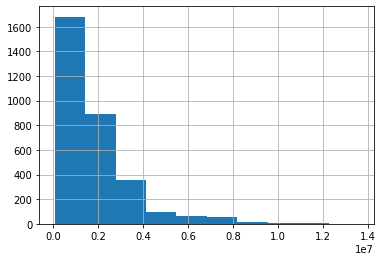

In [21]:
display(num_kat(df, 'price'))

In [22]:
# Прологорифмируем переменную
df['price'] = df['price'].apply(lambda x: np.log(x))

In [23]:
df.head()

,bodyType,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,mileage,Комплектация,Привод,Руль,Владельцы,ПТС,Владение,price,train
0,кабриолет,серебристый,бензин,2001,325i 2.5 AT (192 л.с.),2.0,2005.0,CABRIO AUTOMATIC 2.5,автоматическая,2.5 LTR,192 N12,133 000 км,Мультимедиа1Навигационная системаЭлементы экст...,задний,Левый,3 или более,Оригинал,2 года и 1 месяц,13.910821,1
1,внедорожник 5 дв.,чёрный,бензин,2014,4.4 AT (575 л.с.) 4WD,5.0,2018.0,ALLROAD_5_DOORS AUTOMATIC 4.4,автоматическая,4.4 LTR,575 N12,95 000 км,Комфорт12Круиз-контрольПроекционный дисплейЭле...,полный,Левый,2 владельца,Оригинал,2 года и 4 месяца,15.329538,1
2,седан,белый,бензин,2015,730i 2.0 AT (258 л.с.),4.0,2016.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,258 N12,9 150 км,Комфорт15Круиз-контрольЭлектрорегулировка руля...,задний,Левый,1 владелец,Оригинал,NaN,15.226498,1
3,внедорожник 5 дв.,чёрный,бензин,2014,4.4 AT (575 л.с.) 4WD,5.0,2016.0,ALLROAD_5_DOORS AUTOMATIC 4.4,автоматическая,4.4 LTR,575 N12,109 000 км,Комфорт21Круиз-контрольЭлектрорегулировка руля...,полный,Левый,3 или более,Оригинал,3 года и 8 месяцев,15.123843,1
4,седан,чёрный,бензин,2007,525xi 3.0 AT (218 л.с.) 4WD,4.0,2008.0,SEDAN AUTOMATIC 3.0,автоматическая,3.0 LTR,218 N12,120 000 км,not description,полный,Левый,3 или более,Дубликат,NaN,13.369223,1


## Комплектация

Из значений признака "Комлектация", создаем новые признаки. Т.к. этот признак имеет значительное влияние на цену.

In [24]:
bin_cols = ['Android Auto', 'Антипробуксовочная система (ASR)', 'Аудиосистема', 'Блокировка замков задних дверей',
            'Декоративные молдинги', 'Диски 18', 'Кожа (Материал салона)', 'Кондиционер', 'Круиз-контроль',
            'Ксеноновые/Биксеноновые фары', 'Легкосплавные диски', 'Металлик', 'Мультимедиа система с ЖК-экраном',
            'Накладки на пороги', 'Омыватель фар', 'Панорамная крыша / лобовое стекло', 'Парктроник задний', 'Пневмоподвеска',
            'Подогрев задних сидений', 'Подогрев передних сидений', 'Подушка безопасности пассажира',
            'Противотуманные фары', 'Рейлинги на крыше', 'Розетка 12V', 'Светлый салон', 'Сигнализация',
            'Сигнализация с обратной связью', 'Система стабилизации (ESP)', 'Система доступа без ключа', 'Тонированные стекла',
            'Третий задний подголовник', 'Центральный замок', 'Электронная приборная панель', 'Электрообогрев лобового стекла',
            'Электрообогрев боковых зеркал', 'Электростеклоподъёмники передние', 'Электропривод зеркал']
for col in bin_cols:
    df[col] = df['Комплектация'].str.contains(col).astype(int)
df.drop(['Комплектация'], axis=1, inplace=True)

In [25]:
df.head(15)

,bodyType,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,mileage,Привод,Руль,Владельцы,ПТС,Владение,price,train,Android Auto,Антипробуксовочная система (ASR),Аудиосистема,Блокировка замков задних дверей,Декоративные молдинги,Диски 18,Кожа (Материал салона),Кондиционер,Круиз-контроль,Ксеноновые/Биксеноновые фары,Легкосплавные диски,Металлик,Мультимедиа система с ЖК-экраном,Накладки на пороги,Омыватель фар,Панорамная крыша / лобовое стекло,Парктроник задний,Пневмоподвеска,Подогрев задних сидений,Подогрев передних сидений,Подушка безопасности пассажира,Противотуманные фары,Рейлинги на крыше,Розетка 12V,Светлый салон,Сигнализация,Сигнализация с обратной связью,Система стабилизации (ESP),Система доступа без ключа,Тонированные стекла,Третий задний подголовник,Центральный замок,Электронная приборная панель,Электрообогрев лобового стекла,Электрообогрев боковых зеркал,Электростеклоподъёмники передние,Электропривод зеркал
0,кабриолет,серебристый,бензин,2001,325i 2.5 AT (192 л.с.),2.0,2005.0,CABRIO AUTOMATIC 2.5,автоматическая,2.5 LTR,192 N12,133 000 км,задний,Левый,3 или более,Оригинал,2 года и 1 месяц,13.910821,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,внедорожник 5 дв.,чёрный,бензин,2014,4.4 AT (575 л.с.) 4WD,5.0,2018.0,ALLROAD_5_DOORS AUTOMATIC 4.4,автоматическая,4.4 LTR,575 N12,95 000 км,полный,Левый,2 владельца,Оригинал,2 года и 4 месяца,15.329538,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,1,1,0,0,0,1,1,1,0,1,0,0,1,1,0,1,0,0,0,0,1
2,седан,белый,бензин,2015,730i 2.0 AT (258 л.с.),4.0,2016.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,258 N12,9 150 км,задний,Левый,1 владелец,Оригинал,NaN,15.226498,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,1,0,1
3,внедорожник 5 дв.,чёрный,бензин,2014,4.4 AT (575 л.с.) 4WD,5.0,2016.0,ALLROAD_5_DOORS AUTOMATIC 4.4,автоматическая,4.4 LTR,575 N12,109 000 км,полный,Левый,3 или более,Оригинал,3 года и 8 месяцев,15.123843,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,1,1,1,1,0,0,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1
4,седан,чёрный,бензин,2007,525xi 3.0 AT (218 л.с.) 4WD,4.0,2008.0,SEDAN AUTOMATIC 3.0,автоматическая,3.0 LTR,218 N12,120 000 км,полный,Левый,3 или более,Дубликат,NaN,13.369223,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,внедорожник 5 дв.,чёрный,дизель,2010,20d xDrive 2.0d AT (184 л.с.) 4WD,5.0,2010.0,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,2.0 LTR,184 N12,121 000 км,полный,Левый,1 владелец,Оригинал,NaN,13.849912,1,0,0,1,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,1,1,1,0,1,1,0,0,1,1,1,0,1,1,0,1
6,седан,серый,бензин,2011,4.4 AMT (560 л.с.),4.0,2012.0,SEDAN ROBOT 4.4,роботизированная,4.4 LTR,560 N12,60 000 км,задний,Левый,3 или более,Оригинал,NaN,14.557448,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1
7,седан,серый,бензин,2020,Competition 4.4 AT (625 л.с.) 4WD,4.0,2020.0,SEDAN AUTOMATIC 4.4,автоматическая,4.4 LTR,625 N12,5 км,полный,Левый,1 владелец,Оригинал,NaN,16.222456,1,0,0,0,1,0,0,0,0,1,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,1,0,1,0,1
8,седан,серый,бензин,2018,M340i xDrive 3.0 AT (387 л.с.) 4WD,4.0,2020.0,SEDAN AUTOMATIC 3.0,автоматическая,3.0 LTR,387 N12,2 853 км,левый,Не требует ремонта,Оригинал,Растаможен,До марта 2022,15.424748,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9,купе,серый,дизель,2018,840d xDrive 3.0d AT (320 л.с.) 4WD,2.0,2018.0,COUPE AUTOMATIC 3.0,автоматическая,3.0 LTR,320 N12,28 768 км,полный,Левый,3 или более,Оригинал,NaN,15.635290,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,1,1,0,1,0,1


## bodyType - тип кузова

Количество пропущенных значений: 0
Количество уникальных значений: 11


седан                2979
внедорожник 5 дв.    2860
купе                  419
хэтчбек 5 дв.         284
лифтбек               233
универсал 5 дв.        74
хэтчбек 3 дв.          68
кабриолет              53
родстер                25
компактвэн              8
седан 2 дв.             5
Name: bodyType, dtype: int64

None

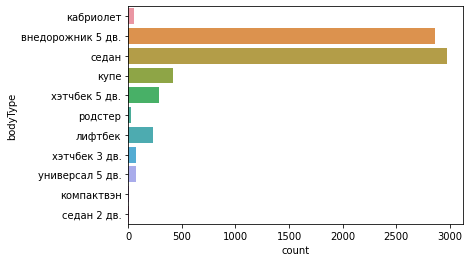

In [26]:
display(info_kat(df, 'bodyType'))

In [27]:
# Рассмотрим как распределены между собой признаки тип кузова и количество дверей
pd.crosstab(df['bodyType'], df['numberOfDoors'].astype(int))

numberOfDoors,2,3,4,5
bodyType,,,,
внедорожник 5 дв.,0,0,0,2860
кабриолет,53,0,0,0
компактвэн,0,0,0,8
купе,419,0,0,0
лифтбек,0,0,0,233
родстер,25,0,0,0
седан,0,0,2979,0
седан 2 дв.,5,0,0,0
универсал 5 дв.,0,0,0,74


Видно по таблице, что каждый тип кузова представлен единственным количеством дверей. Таким образом, признак <code>numberOfDoors</code>	является избыточным, удаляем его.

In [28]:
df.drop(['numberOfDoors'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7008 entries, 0 to 7007
Data columns (total 55 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   bodyType                           7008 non-null   object 
 1   color                              7008 non-null   object 
 2   fuelType                           7008 non-null   object 
 3   modelDate                          7008 non-null   object 
 4   name                               7008 non-null   object 
 5   productionDate                     7008 non-null   float64
 6   vehicleConfiguration               7008 non-null   object 
 7   vehicleTransmission                7008 non-null   object 
 8   engineDisplacement                 7008 non-null   object 
 9   enginePower                        7008 non-null   object 
 10  mileage                            7008 non-null   object 
 11  Привод                             7008 non-null   objec

## color - цвет машины

Количество пропущенных значений: 0
Количество уникальных значений: 15


чёрный         2623
белый          1331
синий           920
серый           829
серебристый     373
коричневый      360
красный         214
бежевый          83
зелёный          74
голубой          73
оранжевый        45
золотистый       36
пурпурный        32
фиолетовый       10
жёлтый            5
Name: color, dtype: int64

None

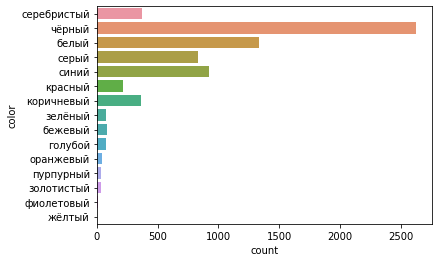

In [29]:
display(info_kat(df, 'color'))

## fuelType - тип топлива

Количество пропущенных значений: 0
Количество уникальных значений: 4


бензин     4600
дизель     2382
гибрид       18
электро       8
Name: fuelType, dtype: int64

None

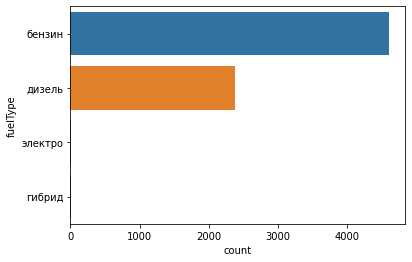

In [30]:
display(info_kat(df, 'fuelType'))

## modelDate - год модели

Количество пропущенных значений: 0
Основная статистика:


count    7008.000000
mean     2009.470605
std         6.498399
min      1936.000000
25%      2007.000000
50%      2010.000000
75%      2014.000000
max      2020.000000
Name: modelDate, dtype: float64

None

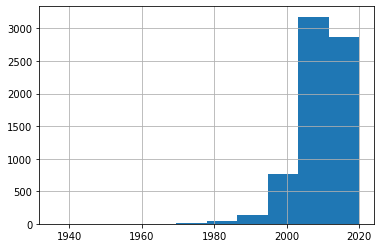

In [31]:
df['modelDate'] = df['modelDate'].astype(int)
display(num_kat(df, 'modelDate'))

25-й перцентиль: 2007.0, 75-й перцентиль: 2014.0, IQR: 7.0,  Границы выбросов: [1996.5, 2024.5].


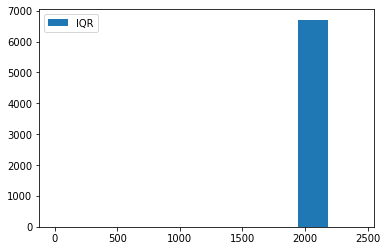

In [32]:
vubros(df['modelDate'])

In [33]:
# Посмотрим на машины, год модели которой меньше 1996
df[df['modelDate'] < 1996]

,bodyType,color,fuelType,modelDate,name,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,mileage,Привод,Руль,Владельцы,ПТС,Владение,price,train,Android Auto,Антипробуксовочная система (ASR),Аудиосистема,Блокировка замков задних дверей,Декоративные молдинги,Диски 18,Кожа (Материал салона),Кондиционер,Круиз-контроль,Ксеноновые/Биксеноновые фары,Легкосплавные диски,Металлик,Мультимедиа система с ЖК-экраном,Накладки на пороги,Омыватель фар,Панорамная крыша / лобовое стекло,Парктроник задний,Пневмоподвеска,Подогрев задних сидений,Подогрев передних сидений,Подушка безопасности пассажира,Противотуманные фары,Рейлинги на крыше,Розетка 12V,Светлый салон,Сигнализация,Сигнализация с обратной связью,Система стабилизации (ESP),Система доступа без ключа,Тонированные стекла,Третий задний подголовник,Центральный замок,Электронная приборная панель,Электрообогрев лобового стекла,Электрообогрев боковых зеркал,Электростеклоподъёмники передние,Электропривод зеркал
111,седан,серый,бензин,1981,520i 2.0 MT (125 л.с.),1983.0,SEDAN MECHANICAL 2.0,механическая,2.0 LTR,125 N12,300 000 км,задний,Левый,3 или более,Дубликат,1 месяц,13.017003,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
118,седан,серый,бензин,1987,520i 2.0 MT (129 л.с.),1988.0,SEDAN MECHANICAL 2.0,механическая,2.0 LTR,129 N12,235 000 км,задний,Левый,1 владелец,Оригинал,NaN,13.120361,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
148,универсал 5 дв.,зелёный,бензин,1987,525i 2.5 AT (192 л.с.),1992.0,WAGON_5_DOORS AUTOMATIC 2.5,автоматическая,2.5 LTR,192 N12,290 000 км,задний,Левый,3 или более,Оригинал,1 год и 5 месяцев,12.628067,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1
168,седан,серебристый,бензин,1995,523i 2.5 AT (170 л.с.),1998.0,SEDAN AUTOMATIC 2.5,автоматическая,2.5 LTR,170 N12,364 417 км,задний,Левый,3 или более,Оригинал,10 лет и 1 месяц,12.524526,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
284,седан,синий,дизель,1987,525d 2.5d MT (143 л.с.),1995.0,SEDAN MECHANICAL 2.5,механическая,2.5 LTR,143 N12,300 000 км,задний,Левый,1 владелец,Оригинал,2 года и 9 месяцев,11.608236,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6810,седан,синий,бензин,1987,535i 3.4 MT (211 л.с.),1989.0,SEDAN MECHANICAL 3.4,механическая,3.4 LTR,211 N12,300000,задний,Левый,3 или более,Дубликат,3 года и 6 месяцев,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
6884,седан,зелёный,бензин,1987,520i 2.0 MT (150 л.с.),1995.0,SEDAN MECHANICAL 2.0,механическая,2.0 LTR,150 N12,520416,задний,Левый,3 или более,Дубликат,7 лет и 4 месяца,NaN,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,1,1,0,0,1,0,1
6890,купе,чёрный,бензин,1990,328i 2.8 AT (193 л.с.),1995.0,COUPE AUTOMATIC 2.8,автоматическая,2.8 LTR,193 N12,312000,задний,Левый,3 или более,Оригинал,1 год и 7 месяцев,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1
6960,седан,серый,бензин,1982,316 1.8 MT (90 л.с.),1982.0,SEDAN MECHANICAL 1.8,механическая,1.8 LTR,90 N12,190000,задний,Левый,3 или более,Оригинал,3 месяца,NaN,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


У нас много таких моделей, они присутствуют как в тестовой, так и обучащей выборки. Следовательно, оставляем их.

## name

Количество пропущенных значений: 0
Количество уникальных значений: 801


35i 3.0 AT (306 л.с.) 4WD            193
30d 3.0d AT (249 л.с.) 4WD           148
35i 3.0 AT (306 л.с.) 4WD            146
30d 3.0d AT (249 л.с.) 4WD           132
520i 2.0 AT (184 л.с.)               103
                                    ... 
530i xDrive 2.0 AT (252 л.с.) 4WD      1
540i 4.0 AT (306 л.с.)                 1
30i 3.0 MT (231 л.с.) 4WD              1
740Li 4.4 AT (286 л.с.)                1
528i 3.0 AT (258 л.с.) 4WD             1
Name: name, Length: 801, dtype: int64

None

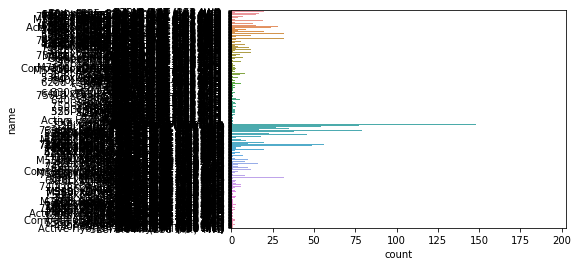

In [34]:
display(info_kat(df, 'name'))

Видим, что данные собраны не совсем корректо, и одно и тоже имя воспринимается пандасом как разные. 

In [35]:
df[df['name'].str.match('35i')]['name']

13      35i 3.0 AT (306 л.с.) 4WD 
37      35i 3.0 AT (306 л.с.) 4WD 
41      35i 3.0 AT (306 л.с.) 4WD 
70      35i 3.0 AT (306 л.с.) 4WD 
121     35i 3.0 AT (306 л.с.) 4WD 
                   ...            
6891     35i 3.0 AT (306 л.с.) 4WD
6929     35i 3.0 AT (306 л.с.) 4WD
6931     35i 3.0 AT (306 л.с.) 4WD
6966     35i 3.0 AT (306 л.с.) 4WD
6970     35i 3.0 AT (306 л.с.) 4WD
Name: name, Length: 353, dtype: object

Чтобы значения признака считались корректно, удалим пробелы в конце строк

In [36]:
df['name'] = df['name'].str.strip()

Количество пропущенных значений: 0
Количество уникальных значений: 500


35i 3.0 AT (306 л.с.) 4WD            339
30d 3.0d AT (249 л.с.) 4WD           280
520i 2.0 AT (184 л.с.)               154
320i xDrive 2.0 AT (184 л.с.) 4WD    150
320i 2.0 AT (184 л.с.)               141
                                    ... 
220i 2.0 MT (184 л.с.)                 1
325i 2.5 MT (218 л.с.)                 1
730d 2.9d AT (193 л.с.)                1
530d 2.9d AT (193 л.с.)                1
2.5 MT (150 л.с.)                      1
Name: name, Length: 500, dtype: int64

None

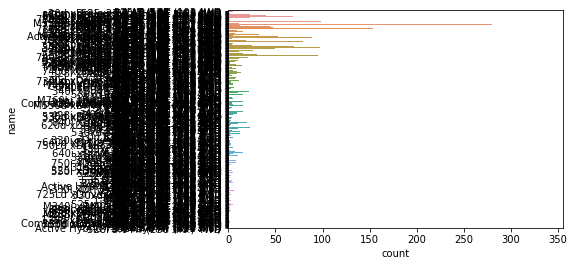

In [37]:
display(info_kat(df, 'name'))

После преобразования, количество уникальных значений в столбце уменьшилось с 819 до 509. Данный признак содержит объединенную информацию из других признаков: vehicleConfiguration,  vehicleTransmission,engineDisplacement, enginePower. Поэтому делать дамми признаки из этого признака не целесообразно.

In [38]:
df.drop(['name'], axis=1, inplace=True)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7008 entries, 0 to 7007
Data columns (total 54 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   bodyType                           7008 non-null   object 
 1   color                              7008 non-null   object 
 2   fuelType                           7008 non-null   object 
 3   modelDate                          7008 non-null   int64  
 4   productionDate                     7008 non-null   float64
 5   vehicleConfiguration               7008 non-null   object 
 6   vehicleTransmission                7008 non-null   object 
 7   engineDisplacement                 7008 non-null   object 
 8   enginePower                        7008 non-null   object 
 9   mileage                            7008 non-null   object 
 10  Привод                             7008 non-null   object 
 11  Руль                               7008 non-null   objec

## productionDate - дата выпуска машины

Количество пропущенных значений: 0
Основная статистика:


count    7008.000000
mean     2011.490297
std         6.164129
min      1937.000000
25%      2009.000000
50%      2012.000000
75%      2016.000000
max      2020.000000
Name: productionDate, dtype: float64

None

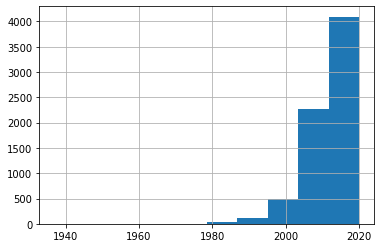

In [40]:
df['productionDate'] = df['productionDate'].astype(int)
display(num_kat(df, 'productionDate'))

Дата выпуска, как и год модели, также будут иметь значения, которые будут значительно отличатся от общей выборки.

## vehicleConfiguration

Количество пропущенных значений: 0
Количество уникальных значений: 131


ALLROAD_5_DOORS AUTOMATIC 3.0      1526
SEDAN AUTOMATIC 2.0                1299
ALLROAD_5_DOORS AUTOMATIC 2.0       864
SEDAN AUTOMATIC 3.0                 646
ALLROAD_5_DOORS AUTOMATIC 4.4       307
                                   ... 
HATCHBACK_3_DOORS AUTOMATIC 2.5       1
SEDAN AUTOMATIC 3.9                   1
SEDAN MECHANICAL 2.3                  1
CABRIO AUTOMATIC 2.8                  1
SEDAN AUTOMATIC 1.8                   1
Name: vehicleConfiguration, Length: 131, dtype: int64

None

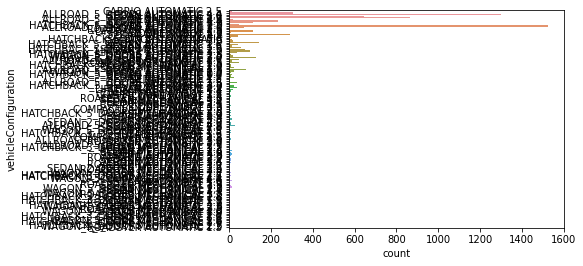

In [41]:
display(info_kat(df, 'vehicleConfiguration'))

## vehicleTransmission - тип трансмиссии

Количество пропущенных значений: 0
Количество уникальных значений: 3


автоматическая      6604
механическая         307
роботизированная      97
Name: vehicleTransmission, dtype: int64

None

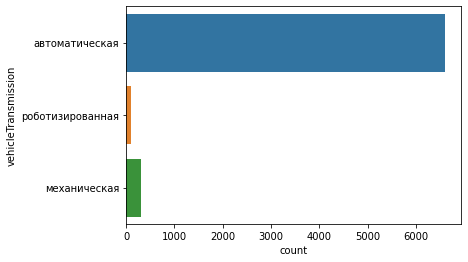

In [42]:
display(info_kat(df, 'vehicleTransmission'))

## engineDisplacement

In [43]:
df['engineDisplacement'].value_counts()

2.0 LTR          2607
3.0 LTR          2481
4.4 LTR           632
2.5 LTR           462
1.6 LTR           285
1.5 LTR           129
4.8 LTR           113
2.2 LTR            52
2.8 LTR            39
1.8 LTR            34
4.0 LTR            32
1.9 LTR            19
6.0 LTR            14
3.5 LTR            14
2.9 LTR            13
5.0 LTR            12
6.6 LTR            11
5.4 LTR            10
4.6 LTR             9
3.6 LTR             7
 LTR                7
3.4 LTR             7
0.7 LTR             6
3.2 LTR             3
3.8 LTR             2
3.3 LTR             2
2.3 LTR             1
3.9 LTR             1
2.4 LTR             1
undefined LTR       1
2.7 LTR             1
1.7 LTR             1
Name: engineDisplacement, dtype: int64

In [44]:
# Функция, чтобы достать числовие значения из признака
def change_function(row):
    result = re.match(r'\d\.\d', row)
    if result != None:
        return result.group(0)
    else:
        return 0

In [45]:
df['engineDisplacement'] = df['engineDisplacement'].apply(change_function)

In [46]:
# Проверяем количество пустых строк
df[df['engineDisplacement'].isnull()]

,bodyType,color,fuelType,modelDate,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,mileage,Привод,Руль,Владельцы,ПТС,Владение,price,train,Android Auto,Антипробуксовочная система (ASR),Аудиосистема,Блокировка замков задних дверей,Декоративные молдинги,Диски 18,Кожа (Материал салона),Кондиционер,Круиз-контроль,Ксеноновые/Биксеноновые фары,Легкосплавные диски,Металлик,Мультимедиа система с ЖК-экраном,Накладки на пороги,Омыватель фар,Панорамная крыша / лобовое стекло,Парктроник задний,Пневмоподвеска,Подогрев задних сидений,Подогрев передних сидений,Подушка безопасности пассажира,Противотуманные фары,Рейлинги на крыше,Розетка 12V,Светлый салон,Сигнализация,Сигнализация с обратной связью,Система стабилизации (ESP),Система доступа без ключа,Тонированные стекла,Третий задний подголовник,Центральный замок,Электронная приборная панель,Электрообогрев лобового стекла,Электрообогрев боковых зеркал,Электростеклоподъёмники передние,Электропривод зеркал


In [47]:
# Пропущенные значения у электрокаров, поэтому оставим им значение 0
df['engineDisplacement'].dropna(0, inplace=True)
df['engineDisplacement'] = df['engineDisplacement'].astype(float)

Количество пропущенных значений: 0
Основная статистика:


count    7008.000000
mean        2.671561
std         0.850813
min         0.000000
25%         2.000000
50%         2.500000
75%         3.000000
max         6.600000
Name: engineDisplacement, dtype: float64

None

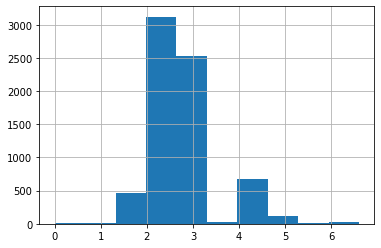

In [48]:
display(num_kat(df, 'engineDisplacement'))

## enginePower

In [49]:
df['enginePower'].head(10)

0    192 N12
1    575 N12
2    258 N12
3    575 N12
4    218 N12
5    184 N12
6    560 N12
7    625 N12
8    387 N12
9    320 N12
Name: enginePower, dtype: object

In [50]:
# Функция, чтобы достать числовие значения из признака - количество лошадиных сил
def change_function2(row):
    result = re.match(r'\d\d\d', row)
    if result != None:
        return int(result.group(0))
    else:
        return np.nan


df['enginePower'] = df['enginePower'].apply(change_function2)

Количество пропущенных значений: 12
Основная статистика:


count    6996.000000
mean      246.794454
std        96.572831
min       100.000000
25%       184.000000
50%       231.000000
75%       306.000000
max       625.000000
Name: enginePower, dtype: float64

None

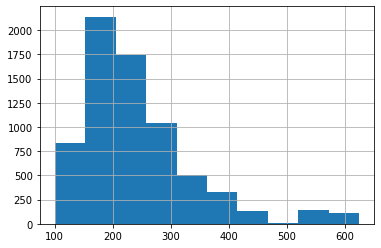

In [51]:
display(num_kat(df, 'enginePower'))

In [52]:
df['enginePower'].fillna(df['enginePower'].min(), inplace=True)

## mileage - пробег

In [53]:
df['mileage'].head(10)

0    133 000 км
1     95 000 км
2      9 150 км
3    109 000 км
4    120 000 км
5    121 000 км
6     60 000 км
7          5 км
8      2 853 км
9     28 768 км
Name: mileage, dtype: object

In [54]:
df['mileage'].tail(10)

6998    107000
6999     23597
7000     11400
7001    119763
7002    100720
7003     98000
7004    169615
7005    180000
7006    137500
7007     89905
Name: mileage, dtype: object

In [55]:
def func_mileage(row):
    if 'км' in str(row):
        row = row.replace(u'\xa0', u'')
        row.replace(' ', '')
        return int(row[:-2])
    else:
        return int(row)

In [56]:
df['mileage'] = df['mileage'].apply(func_mileage)

Количество пропущенных значений: 0
Основная статистика:


count       7008.000000
mean      127287.309361
std        92669.267344
min            1.000000
25%        61500.000000
50%       113707.500000
75%       173405.000000
max      1000000.000000
Name: mileage, dtype: float64

None

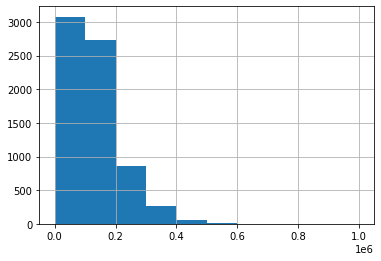

In [57]:
display(num_kat(df, 'mileage'))

25-й перцентиль: 61500.0, 75-й перцентиль: 173405.0, IQR: 111905.0,  Границы выбросов: [-106357.5, 341262.5].


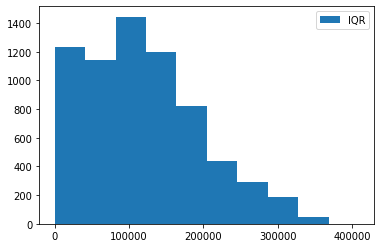

In [58]:
vubros(df['mileage'])

In [59]:
# Посмотрим сколько машин, имеют пробег больше 341900 км
df[(df['mileage'] > 341900)].shape

(209, 54)

## Привод

Количество пропущенных значений: 0
Количество уникальных значений: 5


полный            4347
задний            2623
передний            28
автоматическая       7
левый                3
Name: Привод, dtype: int64

None

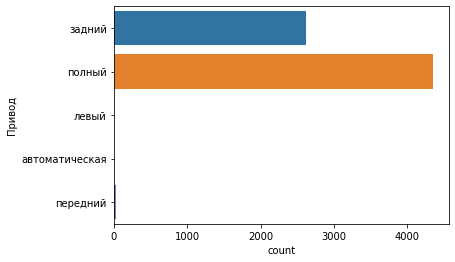

In [60]:
display(info_kat(df, 'Привод'))

Видно, что во время парсинга, что то пошло не так (баг), и в данный признак попали не корректные данные.

In [61]:
# Смотрим на первое некорректное значение
df[df['Привод'] == 'автоматическая']

,bodyType,color,fuelType,modelDate,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,mileage,Привод,Руль,Владельцы,ПТС,Владение,price,train,Android Auto,Антипробуксовочная система (ASR),Аудиосистема,Блокировка замков задних дверей,Декоративные молдинги,Диски 18,Кожа (Материал салона),Кондиционер,Круиз-контроль,Ксеноновые/Биксеноновые фары,Легкосплавные диски,Металлик,Мультимедиа система с ЖК-экраном,Накладки на пороги,Омыватель фар,Панорамная крыша / лобовое стекло,Парктроник задний,Пневмоподвеска,Подогрев задних сидений,Подогрев передних сидений,Подушка безопасности пассажира,Противотуманные фары,Рейлинги на крыше,Розетка 12V,Светлый салон,Сигнализация,Сигнализация с обратной связью,Система стабилизации (ESP),Система доступа без ключа,Тонированные стекла,Третий задний подголовник,Центральный замок,Электронная приборная панель,Электрообогрев лобового стекла,Электрообогрев боковых зеркал,Электростеклоподъёмники передние,Электропривод зеркал
74,хэтчбек 5 дв.,белый,электро,2017,2018,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,0.0,170.0,25000,автоматическая,задний,Не требует ремонта,1 владелец,Оригинал,14.612567,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,1
120,хэтчбек 5 дв.,белый,электро,2017,2018,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,0.0,170.0,25000,автоматическая,задний,Не требует ремонта,1 владелец,Оригинал,14.612567,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,1
800,хэтчбек 5 дв.,бежевый,электро,2013,2017,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,0.0,170.0,39000,автоматическая,задний,Не требует ремонта,1 владелец,Оригинал,14.571633,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
915,хэтчбек 5 дв.,серый,электро,2013,2014,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,0.0,170.0,51000,автоматическая,задний,Не требует ремонта,1 владелец,Оригинал,14.508658,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1120,хэтчбек 5 дв.,чёрный,электро,2013,2016,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,0.0,170.0,78000,автоматическая,задний,Не требует ремонта,1 владелец,Оригинал,14.403297,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,1,0,1
1782,хэтчбек 5 дв.,синий,электро,2017,2018,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,0.0,170.0,32000,автоматическая,задний,Не требует ремонта,1 владелец,Оригинал,14.677978,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2070,хэтчбек 5 дв.,чёрный,электро,2017,2017,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,0.0,170.0,39500,автоматическая,задний,Не требует ремонта,1 владелец,Оригинал,14.700801,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0


In [62]:
# По таблице видно, что данные попали в другой столбец, поэтому просто заменяем их на корректиное значение "задний"

In [63]:
# Рассматриваем второе некорректное значение
df[df['Привод'] == 'левый']

,bodyType,color,fuelType,modelDate,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,mileage,Привод,Руль,Владельцы,ПТС,Владение,price,train,Android Auto,Антипробуксовочная система (ASR),Аудиосистема,Блокировка замков задних дверей,Декоративные молдинги,Диски 18,Кожа (Материал салона),Кондиционер,Круиз-контроль,Ксеноновые/Биксеноновые фары,Легкосплавные диски,Металлик,Мультимедиа система с ЖК-экраном,Накладки на пороги,Омыватель фар,Панорамная крыша / лобовое стекло,Парктроник задний,Пневмоподвеска,Подогрев задних сидений,Подогрев передних сидений,Подушка безопасности пассажира,Противотуманные фары,Рейлинги на крыше,Розетка 12V,Светлый салон,Сигнализация,Сигнализация с обратной связью,Система стабилизации (ESP),Система доступа без ключа,Тонированные стекла,Третий задний подголовник,Центральный замок,Электронная приборная панель,Электрообогрев лобового стекла,Электрообогрев боковых зеркал,Электростеклоподъёмники передние,Электропривод зеркал
8,седан,серый,бензин,2018,2020,SEDAN AUTOMATIC 3.0,автоматическая,3.0,387.0,2853,левый,Не требует ремонта,Оригинал,Растаможен,До марта 2022,15.424748,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
113,внедорожник 5 дв.,серый,бензин,2006,2008,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3.0,272.0,230880,левый,Не требует ремонта,Оригинал,Растаможен,Рассмотрю варианты,13.392391,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1
244,внедорожник 5 дв.,чёрный,бензин,2014,2016,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3.0,306.0,93000,левый,Не требует ремонта,Оригинал,1 год и 11 месяцев,NaN,14.845130,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,0,1,0,1


In [64]:
# Для того, чтобы понять, чем его заменить, рассмотрим все варианты для этой модели
df[(df['vehicleConfiguration'] == 'SEDAN AUTOMATIC 2.0') & (
    df['modelDate'] == 2013) & (df['enginePower'] == 245.0)]

,bodyType,color,fuelType,modelDate,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,mileage,Привод,Руль,Владельцы,ПТС,Владение,price,train,Android Auto,Антипробуксовочная система (ASR),Аудиосистема,Блокировка замков задних дверей,Декоративные молдинги,Диски 18,Кожа (Материал салона),Кондиционер,Круиз-контроль,Ксеноновые/Биксеноновые фары,Легкосплавные диски,Металлик,Мультимедиа система с ЖК-экраном,Накладки на пороги,Омыватель фар,Панорамная крыша / лобовое стекло,Парктроник задний,Пневмоподвеска,Подогрев задних сидений,Подогрев передних сидений,Подушка безопасности пассажира,Противотуманные фары,Рейлинги на крыше,Розетка 12V,Светлый салон,Сигнализация,Сигнализация с обратной связью,Система стабилизации (ESP),Система доступа без ключа,Тонированные стекла,Третий задний подголовник,Центральный замок,Электронная приборная панель,Электрообогрев лобового стекла,Электрообогрев боковых зеркал,Электростеклоподъёмники передние,Электропривод зеркал
123,седан,белый,бензин,2013,2016,SEDAN AUTOMATIC 2.0,автоматическая,2.0,245.0,73608,полный,Левый,1 владелец,Оригинал,NaN,14.647985,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
163,седан,белый,бензин,2013,2016,SEDAN AUTOMATIC 2.0,автоматическая,2.0,245.0,88173,полный,Левый,1 владелец,Оригинал,NaN,14.602603,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
210,седан,синий,бензин,2013,2013,SEDAN AUTOMATIC 2.0,автоматическая,2.0,245.0,64440,полный,Левый,3 или более,Оригинал,NaN,14.144814,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,1,0,1
287,седан,чёрный,бензин,2013,2013,SEDAN AUTOMATIC 2.0,автоматическая,2.0,245.0,134560,полный,Левый,2 владельца,Оригинал,NaN,14.200773,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1,0,1,1,0,1,1,1,1,0,1,1,0,1
289,седан,синий,бензин,2013,2014,SEDAN AUTOMATIC 2.0,автоматическая,2.0,245.0,87000,полный,Левый,3 или более,Оригинал,9 месяцев,14.297937,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6710,седан,синий,бензин,2013,2016,SEDAN AUTOMATIC 2.0,автоматическая,2.0,245.0,111000,полный,Левый,1 владелец,Оригинал,3 года и 2 месяца,NaN,0,0,0,1,1,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,1,1,1,0,1,0,1
6846,седан,бежевый,бензин,2013,2013,SEDAN AUTOMATIC 2.0,автоматическая,2.0,245.0,97000,полный,Левый,3 или более,Оригинал,1 год и 1 месяц,NaN,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1
6870,седан,чёрный,бензин,2013,2016,SEDAN AUTOMATIC 2.0,автоматическая,2.0,245.0,34200,полный,Левый,1 владелец,Оригинал,3 года и 1 месяц,NaN,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1
6897,седан,чёрный,бензин,2013,2014,SEDAN AUTOMATIC 2.0,автоматическая,2.0,245.0,159000,полный,Левый,2 владельца,Оригинал,NaN,NaN,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,1,0,1


In [65]:
# заменяем на "полный"
df[(df['vehicleConfiguration'] == 'SEDAN AUTOMATIC 2.0') & (df['modelDate'] == 2013)
    & (df['enginePower'] == 245.0) & (df['Привод'] == 'левый')][['Привод']] = 'полный'

In [66]:
df[(df['vehicleConfiguration'] == 'SEDAN AUTOMATIC 2.0') & (
    df['modelDate'] == 2018) & (df['enginePower'] == 190.0)]

,bodyType,color,fuelType,modelDate,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,mileage,Привод,Руль,Владельцы,ПТС,Владение,price,train,Android Auto,Антипробуксовочная система (ASR),Аудиосистема,Блокировка замков задних дверей,Декоративные молдинги,Диски 18,Кожа (Материал салона),Кондиционер,Круиз-контроль,Ксеноновые/Биксеноновые фары,Легкосплавные диски,Металлик,Мультимедиа система с ЖК-экраном,Накладки на пороги,Омыватель фар,Панорамная крыша / лобовое стекло,Парктроник задний,Пневмоподвеска,Подогрев задних сидений,Подогрев передних сидений,Подушка безопасности пассажира,Противотуманные фары,Рейлинги на крыше,Розетка 12V,Светлый салон,Сигнализация,Сигнализация с обратной связью,Система стабилизации (ESP),Система доступа без ключа,Тонированные стекла,Третий задний подголовник,Центральный замок,Электронная приборная панель,Электрообогрев лобового стекла,Электрообогрев боковых зеркал,Электростеклоподъёмники передние,Электропривод зеркал
443,седан,чёрный,дизель,2018,2020,SEDAN AUTOMATIC 2.0,автоматическая,2.0,190.0,27000,полный,Левый,1 владелец,Оригинал,NaN,14.962596,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,1,0,1,0,1
478,седан,синий,дизель,2018,2019,SEDAN AUTOMATIC 2.0,автоматическая,2.0,190.0,54000,задний,Левый,2 владельца,Оригинал,11 месяцев,14.747675,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1
574,седан,синий,дизель,2018,2020,SEDAN AUTOMATIC 2.0,автоматическая,2.0,190.0,1000,полный,Левый,1 владелец,Оригинал,NaN,15.181304,1,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1
579,седан,оранжевый,дизель,2018,2020,SEDAN AUTOMATIC 2.0,автоматическая,2.0,190.0,8,полный,Левый,1 владелец,Оригинал,NaN,15.075930,1,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,0,1,0,1
633,седан,оранжевый,дизель,2018,2020,SEDAN AUTOMATIC 2.0,автоматическая,2.0,190.0,6607,полный,Левый,1 владелец,Оригинал,NaN,15.008220,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
713,седан,чёрный,дизель,2018,2020,SEDAN AUTOMATIC 2.0,автоматическая,2.0,190.0,27000,полный,Левый,1 владелец,Оригинал,NaN,14.962596,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,1,0,1,0,1
736,седан,чёрный,дизель,2018,2019,SEDAN AUTOMATIC 2.0,автоматическая,2.0,190.0,28000,полный,Левый,2 владельца,Оригинал,NaN,14.767168,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,0,1,0,1
861,седан,чёрный,дизель,2018,2019,SEDAN AUTOMATIC 2.0,автоматическая,2.0,190.0,20476,полный,Левый,1 владелец,Оригинал,NaN,14.759416,1,0,0,1,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,1,0,1
1327,седан,белый,дизель,2018,2019,SEDAN AUTOMATIC 2.0,автоматическая,2.0,190.0,15000,задний,Левый,1 владелец,Оригинал,NaN,14.930652,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1
1548,седан,серый,дизель,2018,2019,SEDAN AUTOMATIC 2.0,автоматическая,2.0,190.0,22000,полный,Левый,1 владелец,Оригинал,1 год и 2 месяца,14.946913,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,1,1,0,1,1,1,1,0,1,1,0,1


In [67]:
d = {'полный': 'полный', 'передний': 'передний', 'задний': 'задний',
     'левый': 'полный', 'автоматическая': 'задний'}
df['Привод'] = df['Привод'].map(d)

Количество пропущенных значений: 0
Количество уникальных значений: 3


полный      4350
задний      2630
передний      28
Name: Привод, dtype: int64

None

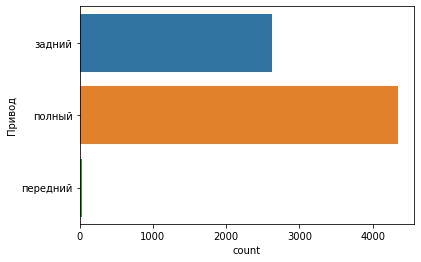

In [68]:
display(info_kat(df, 'Привод'))

## Руль

Количество пропущенных значений: 0
Количество уникальных значений: 4


Левый                 6996
задний                   7
Не требует ремонта       3
Правый                   2
Name: Руль, dtype: int64

None

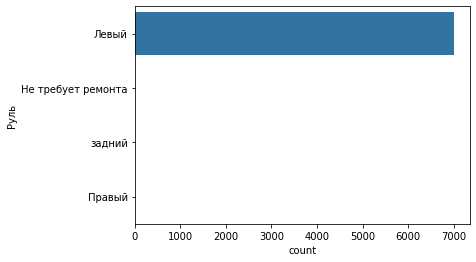

In [69]:
display(info_kat(df, 'Руль'))

Во время парсинга попало несколько ошибочных данных. С учето правостороннего движения на территории РФ, наличие руля с правой стороны крайне редко встречается. Принимаем, что у всех машин руль слева, поэтому можем удалить столбец.

In [70]:
df.drop(['Руль'], axis=1, inplace=True)

## Владельцы

Количество пропущенных значений: 0
Количество уникальных значений: 5


3 или более           2931
1 владелец            2214
2 владельца           1853
Не требует ремонта       7
Оригинал                 3
Name: Владельцы, dtype: int64

None

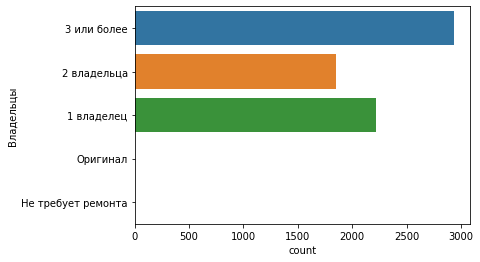

In [71]:
display(info_kat(df, 'Владельцы'))

In [72]:
df['Владельцы'].unique().tolist()

['3 или более',
 '2\xa0владельца',
 '1\xa0владелец',
 'Оригинал',
 'Не требует ремонта']

Т.к. модовое значение в этом признаке "3 или более", заменяем на это значение, некорректные данные.

In [73]:
d1 = {'3 или более': '3 или более', '2\xa0владельца': '2 владельца',
      '1\xa0владелец': '1 владелец', 'Не требует ремонта': '3 или более', 'Оригинал': '3 или более'}
df['Владельцы'] = df['Владельцы'].map(d1)

Количество пропущенных значений: 0
Количество уникальных значений: 3


3 или более    2941
1 владелец     2214
2 владельца    1853
Name: Владельцы, dtype: int64

None

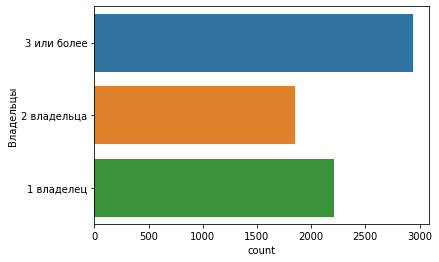

In [74]:
display(info_kat(df, 'Владельцы'))

## ПТС

Количество пропущенных значений: 0
Количество уникальных значений: 5


Оригинал              6148
Дубликат               850
1 владелец               7
Растаможен               2
1 год и 11 месяцев       1
Name: ПТС, dtype: int64

None

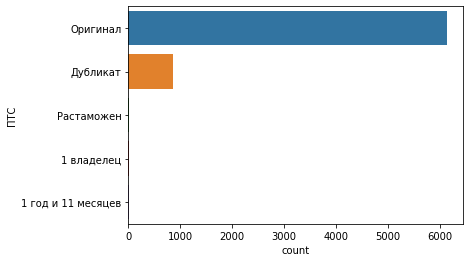

In [75]:
display(info_kat(df, 'ПТС'))

Этот признак также содержит некорректные данные, появившиеся в результате парсинга. Заменим некорректные значения на модовое значение.

In [76]:
df['ПТС'].unique().tolist()

['Оригинал', 'Дубликат', 'Растаможен', '1\xa0владелец', '1 год и 11 месяцев']

In [77]:
# Заменим
d2 = {'Оригинал': 'Оригинал', 'Дубликат': 'Дубликат', '1\xa0владелец': 'Оригинал',
      'Растаможен': 'Оригинал', '1 год и 11 месяцев': 'Оригинал'}
df['ПТС'] = df['ПТС'].map(d2)

Количество пропущенных значений: 0
Количество уникальных значений: 2


Оригинал    6158
Дубликат     850
Name: ПТС, dtype: int64

None

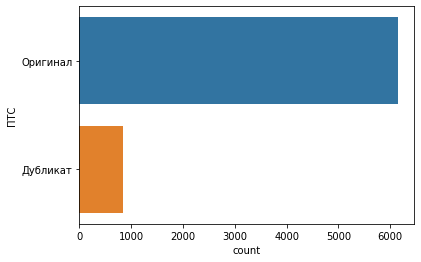

In [78]:
display(info_kat(df, 'ПТС'))

## Владение

Количество пропущенных значений: 4191
Количество уникальных значений: 180


1 год и 4 месяца      60
1 год и 1 месяц       59
1 год и 3 месяца      59
1 год и 2 месяца      56
1 год и 5 месяцев     54
                      ..
10 лет                 1
11 лет и 4 месяца      1
Рассмотрю варианты     1
15 лет и 1 месяц       1
20 лет и 6 месяцев     1
Name: Владение, Length: 180, dtype: int64

None

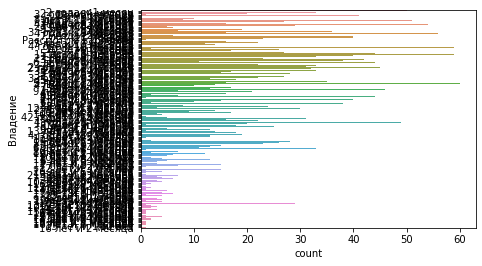

In [79]:
display(info_kat(df, 'Владение'))

Количество пропущенных значений очень велико, удалим данный столбец. Удалим также столбец vehicleConfiguration, т.к. вся информация из него находится в других столбцах.

In [80]:
df.drop(['Владение', 'vehicleConfiguration'], axis=1, inplace=True)

# Предобработка данных

## Числовые признаки

Числовые признаки необходимо нормализовать

In [81]:
num_cols = [
    'modelDate',
    'productionDate',
    'engineDisplacement',
    'enginePower',
    'mileage',
    'price'
]

In [82]:
df[num_cols].isnull().sum()

modelDate                0
productionDate           0
engineDisplacement       0
enginePower              0
mileage                  0
price                 3837
dtype: int64

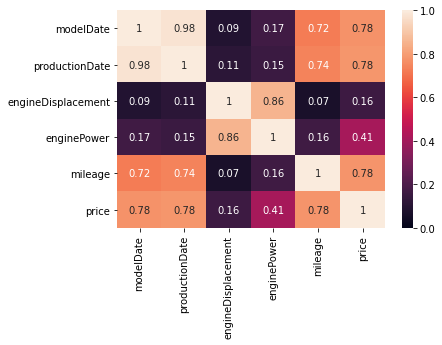

In [83]:
sns.heatmap(df[num_cols].corr().abs(), annot=True, vmin=0, vmax=1)

Некоторые признаки сильно скоррелированы, например дата модели и дата производства машин, что является логичным.  На целевой признак price, значительно влияют - дата модели, дата производства машины, пробег

In [84]:
# Нормализуем данные
num_cols = [
    'modelDate',
    'productionDate',
    'engineDisplacement',
    'enginePower',
    'mileage'
]
mask = (df['train'] == 1)
# df_scaler=pd.DataFrame(columns=num_cols)
scaler = StandardScaler()
scaler.fit(df[mask][num_cols])
df_scaler = pd.DataFrame(scaler.transform(df[num_cols]), columns=num_cols)
df_scaler.head()

,modelDate,productionDate,engineDisplacement,enginePower,mileage
0,-1.047709,-0.834432,-0.252695,-0.579446,-0.048749
1,0.677946,0.987871,1.895245,3.158168,-0.428650
2,0.810689,0.707517,-0.817942,0.064634,-1.286925
3,0.677946,0.707517,1.895245,3.158168,-0.288687
4,-0.251253,-0.413901,0.312553,-0.325717,-0.178715


## Категориальные признаки

Рассмотрим категориальные переменные

In [85]:
cat_cols = [
    'bodyType',
    'color',
    'fuelType',
    'vehicleTransmission',
    'Привод',
    'Владельцы',
    'ПТС'
]
# Проверим значимость признаков


def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='price',
                data=df.loc[df.loc[:, column].isin(
                    df.loc[:, column].value_counts().index[:10])], ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

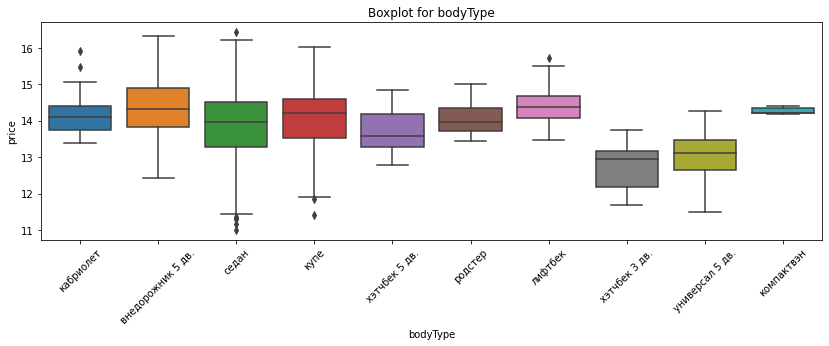

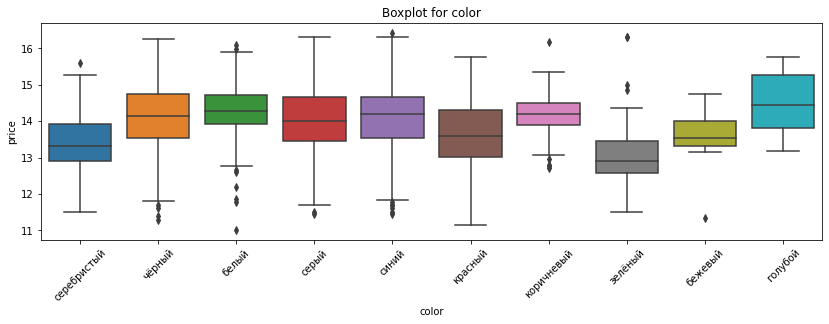

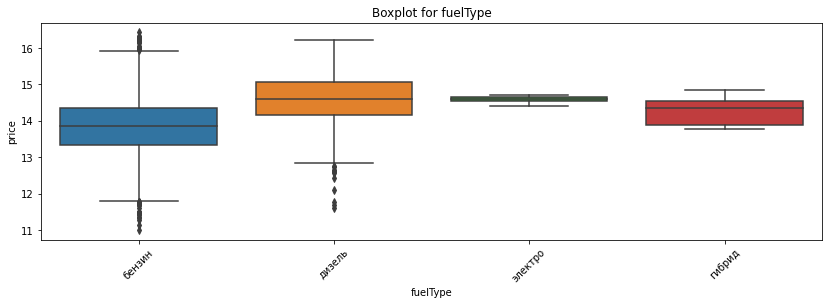

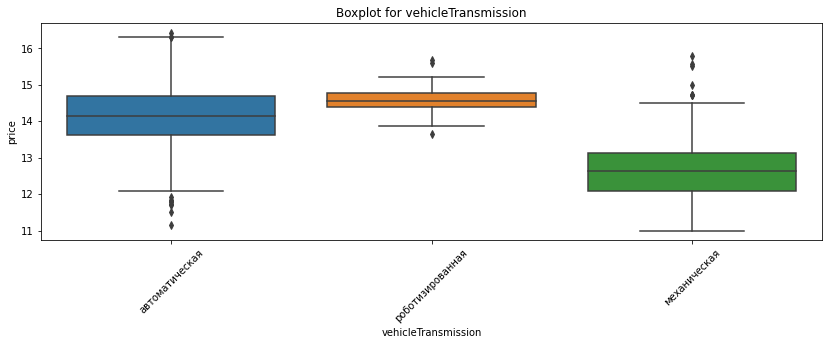

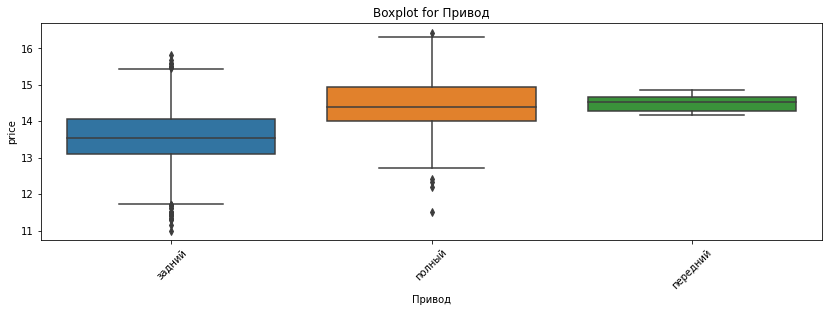

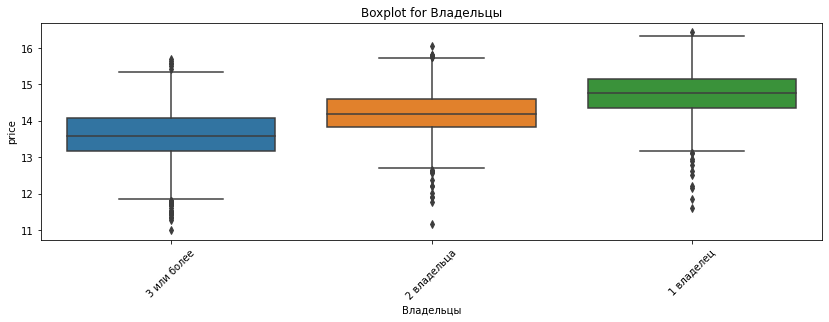

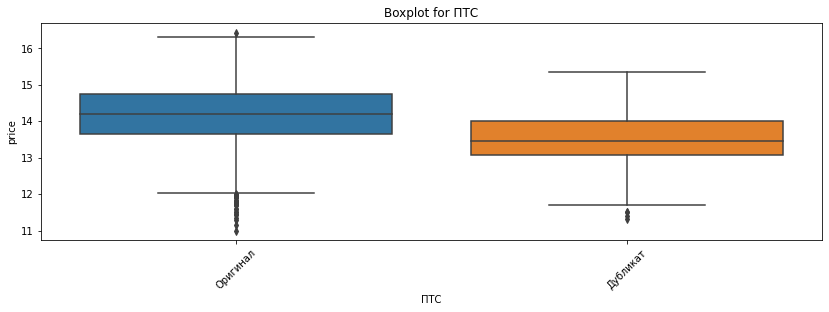

In [86]:
for col in cat_cols:
    get_boxplot(col)

In [87]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'price'],
                     df.loc[df.loc[:, column] == comb[1], 'price']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки - ', column)
            break
        else:
            print('Cтатистически незначимые различия для колонки - ', column)
            break

In [88]:
for col in cat_cols:
    get_stat_dif(col)

Cтатистически незначимые различия для колонки -  bodyType
Cтатистически незначимые различия для колонки -  color
Cтатистически незначимые различия для колонки -  fuelType
Cтатистически незначимые различия для колонки -  vehicleTransmission
Cтатистически незначимые различия для колонки -  Привод
Cтатистически незначимые различия для колонки -  Владельцы
Cтатистически незначимые различия для колонки -  ПТС


Создаем дамми переменные

In [89]:
data_cat = df[cat_cols]
# df_scaler.drop(columns=data_cat,inplace=True,axis=1)
dummy_features = pd.get_dummies(data_cat, drop_first=True)
df_scaler_dummy = pd.concat([df_scaler, dummy_features], axis=1)
df_scaler_dummy[['price', 'train']] = df[['price', 'train']]
df_scaler_dummy = pd.concat([df_scaler_dummy, df[bin_cols]], axis=1)

In [90]:
df_scaler_dummy.head()

,modelDate,productionDate,engineDisplacement,enginePower,mileage,bodyType_кабриолет,bodyType_компактвэн,bodyType_купе,bodyType_лифтбек,bodyType_родстер,bodyType_седан,bodyType_седан 2 дв.,bodyType_универсал 5 дв.,bodyType_хэтчбек 3 дв.,bodyType_хэтчбек 5 дв.,color_белый,color_голубой,color_жёлтый,color_зелёный,color_золотистый,color_коричневый,color_красный,color_оранжевый,color_пурпурный,color_серебристый,color_серый,color_синий,color_фиолетовый,color_чёрный,fuelType_гибрид,fuelType_дизель,fuelType_электро,vehicleTransmission_механическая,vehicleTransmission_роботизированная,Привод_передний,Привод_полный,Владельцы_2 владельца,Владельцы_3 или более,ПТС_Оригинал,price,train,Android Auto,Антипробуксовочная система (ASR),Аудиосистема,Блокировка замков задних дверей,Декоративные молдинги,Диски 18,Кожа (Материал салона),Кондиционер,Круиз-контроль,Ксеноновые/Биксеноновые фары,Легкосплавные диски,Металлик,Мультимедиа система с ЖК-экраном,Накладки на пороги,Омыватель фар,Панорамная крыша / лобовое стекло,Парктроник задний,Пневмоподвеска,Подогрев задних сидений,Подогрев передних сидений,Подушка безопасности пассажира,Противотуманные фары,Рейлинги на крыше,Розетка 12V,Светлый салон,Сигнализация,Сигнализация с обратной связью,Система стабилизации (ESP),Система доступа без ключа,Тонированные стекла,Третий задний подголовник,Центральный замок,Электронная приборная панель,Электрообогрев лобового стекла,Электрообогрев боковых зеркал,Электростеклоподъёмники передние,Электропривод зеркал
0,-1.047709,-0.834432,-0.252695,-0.579446,-0.048749,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,13.910821,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.677946,0.987871,1.895245,3.158168,-0.428650,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,15.329538,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,1,1,0,0,0,1,1,1,0,1,0,0,1,1,0,1,0,0,0,0,1
2,0.810689,0.707517,-0.817942,0.064634,-1.286925,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,15.226498,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,1,0,1
3,0.677946,0.707517,1.895245,3.158168,-0.288687,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,15.123843,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,1,1,1,1,0,0,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1
4,-0.251253,-0.413901,0.312553,-0.325717,-0.178715,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,13.369223,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Обучение моделей

## catboost

In [91]:
!pip install catboost
import catboost

     |████████████████████████████████| 66.2MB 64kB/s 


In [92]:
# Подготовка данных для модели
X_origin_train = df[df['train'] == 1].drop(['train', 'price'], axis=1)
Y_origin_train = df[df['train'] == 1][['price']]
X_origin_test = df[df['train'] == 0].drop(['train', 'price'], axis=1)
X_origin_test.head()

,bodyType,color,fuelType,modelDate,productionDate,vehicleTransmission,engineDisplacement,enginePower,mileage,Привод,Владельцы,ПТС,Android Auto,Антипробуксовочная система (ASR),Аудиосистема,Блокировка замков задних дверей,Декоративные молдинги,Диски 18,Кожа (Материал салона),Кондиционер,Круиз-контроль,Ксеноновые/Биксеноновые фары,Легкосплавные диски,Металлик,Мультимедиа система с ЖК-экраном,Накладки на пороги,Омыватель фар,Панорамная крыша / лобовое стекло,Парктроник задний,Пневмоподвеска,Подогрев задних сидений,Подогрев передних сидений,Подушка безопасности пассажира,Противотуманные фары,Рейлинги на крыше,Розетка 12V,Светлый салон,Сигнализация,Сигнализация с обратной связью,Система стабилизации (ESP),Система доступа без ключа,Тонированные стекла,Третий задний подголовник,Центральный замок,Электронная приборная панель,Электрообогрев лобового стекла,Электрообогрев боковых зеркал,Электростеклоподъёмники передние,Электропривод зеркал
3171,седан,чёрный,дизель,2016,2017,автоматическая,2.0,190.0,158836,задний,1 владелец,Оригинал,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
3172,седан,белый,дизель,2018,2019,автоматическая,2.0,150.0,10,задний,1 владелец,Оригинал,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,0,1,0,1
3173,седан,синий,бензин,2009,2012,автоматическая,4.4,407.0,120000,полный,2 владельца,Оригинал,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,1,1,1,0,1
3174,внедорожник 5 дв.,белый,дизель,2014,2015,автоматическая,3.0,249.0,111466,полный,2 владельца,Оригинал,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1
3175,внедорожник 5 дв.,синий,дизель,2014,2019,автоматическая,3.0,381.0,11891,полный,1 владелец,Оригинал,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1


In [93]:
# Реализуем функцию для вычисления NAPE
def MAPE_score(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [94]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X_origin_train, Y_origin_train, test_size=0.25, random_state=42)

In [95]:
categorical_indices = [0, 1, 2, 5, 9, 10, 11]
cat_boost = catboost.CatBoostRegressor(
    depth=6, learning_rate=0.1, silent=True, cat_features=categorical_indices, eval_metric='MAPE')
cat_boost.fit(X_train_cat, y_train_cat)
print('Mape train:', MAPE_score(y_train_cat, cat_boost.predict(X_train_cat)))
print('Mape test:', MAPE_score(y_test_cat, cat_boost.predict(X_test_cat)))

Mape train: 0.06703433124734963
Mape test: 0.0690084332388384


## BaggingRegressor

In [96]:
X_scaler_train = df_scaler_dummy[df_scaler_dummy['train'] == 1].drop(
    ['train', 'price'], axis=1)
Y_scaler_train = df_scaler_dummy[df_scaler_dummy['train'] == 1][['price']]
X_scaler_test = df_scaler_dummy[df_scaler_dummy['train'] == 0].drop(
    ['train', 'price'], axis=1)
X_scaler_test.head()

,modelDate,productionDate,engineDisplacement,enginePower,mileage,bodyType_кабриолет,bodyType_компактвэн,bodyType_купе,bodyType_лифтбек,bodyType_родстер,bodyType_седан,bodyType_седан 2 дв.,bodyType_универсал 5 дв.,bodyType_хэтчбек 3 дв.,bodyType_хэтчбек 5 дв.,color_белый,color_голубой,color_жёлтый,color_зелёный,color_золотистый,color_коричневый,color_красный,color_оранжевый,color_пурпурный,color_серебристый,color_серый,color_синий,color_фиолетовый,color_чёрный,fuelType_гибрид,fuelType_дизель,fuelType_электро,vehicleTransmission_механическая,vehicleTransmission_роботизированная,Привод_передний,Привод_полный,Владельцы_2 владельца,Владельцы_3 или более,ПТС_Оригинал,Android Auto,Антипробуксовочная система (ASR),Аудиосистема,Блокировка замков задних дверей,Декоративные молдинги,Диски 18,Кожа (Материал салона),Кондиционер,Круиз-контроль,Ксеноновые/Биксеноновые фары,Легкосплавные диски,Металлик,Мультимедиа система с ЖК-экраном,Накладки на пороги,Омыватель фар,Панорамная крыша / лобовое стекло,Парктроник задний,Пневмоподвеска,Подогрев задних сидений,Подогрев передних сидений,Подушка безопасности пассажира,Противотуманные фары,Рейлинги на крыше,Розетка 12V,Светлый салон,Сигнализация,Сигнализация с обратной связью,Система стабилизации (ESP),Система доступа без ключа,Тонированные стекла,Третий задний подголовник,Центральный замок,Электронная приборная панель,Электрообогрев лобового стекла,Электрообогрев боковых зеркал,Электростеклоподъёмники передние,Электропривод зеркал
3171,0.943432,0.847694,-0.817942,-0.598963,0.209543,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
3172,1.208917,1.128049,-0.817942,-0.989315,-1.378302,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,0,1,0,1
3173,0.014233,0.146808,1.895245,1.518693,-0.178715,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,1,1,1,0,1
3174,0.677946,0.567340,0.312553,-0.023195,-0.264033,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1
3175,0.677946,1.128049,0.312553,1.264964,-1.259523,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1


In [97]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_scaler_train, Y_scaler_train, test_size=0.25, random_state=42)

In [98]:
from sklearn import ensemble
bag = ensemble.BaggingRegressor()
bag.fit(X_train_s, y_train_s)
print('Mape train:', MAPE_score(y_train_s, bag.predict(X_train_s)))
print('Mape test:', MAPE_score(y_test_s, bag.predict(X_test_s)))

Mape train: 0.06705267536116061
Mape test: 0.06928959821561145


# Стэкинг


In [99]:
# cat_boost
from sklearn import linear_model, neighbors, tree, ensemble
df_train_predict = pd.DataFrame()
df_test_predict = pd.DataFrame()
categorical_indices = [0, 1, 2, 5, 9, 10, 11]
cat_boost = catboost.CatBoostRegressor(
    l2_leaf_reg=0, learning_rate=0.01, iterations=1500, cat_features=categorical_indices, eval_metric='MAPE')
cat_boost.fit(X_origin_train, Y_origin_train)
df_train_predict['cat_boost'] = cat_boost.predict(X_origin_train)
df_test_predict['cat_boost'] = cat_boost.predict(X_origin_test)

# bagging
model = ensemble.BaggingRegressor(
    max_features=11, n_estimators=23, random_state=42)

model.fit(X_scaler_train, Y_scaler_train)
df_train_predict['BaggingRegr'] = model.predict(X_scaler_train)
df_test_predict['BaggingRegr'] = model.predict(X_scaler_test)

0:	learn: 0.0474637	total: 8.95ms	remaining: 13.4s
1:	learn: 0.0470647	total: 16.8ms	remaining: 12.6s
2:	learn: 0.0466665	total: 24.1ms	remaining: 12s
3:	learn: 0.0462924	total: 31.7ms	remaining: 11.8s
4:	learn: 0.0459069	total: 39.6ms	remaining: 11.8s
5:	learn: 0.0455081	total: 46.3ms	remaining: 11.5s
6:	learn: 0.0451444	total: 54.1ms	remaining: 11.5s
7:	learn: 0.0447877	total: 61.4ms	remaining: 11.5s
8:	learn: 0.0444347	total: 69ms	remaining: 11.4s
9:	learn: 0.0440627	total: 75.6ms	remaining: 11.3s
10:	learn: 0.0437085	total: 82.6ms	remaining: 11.2s
11:	learn: 0.0433703	total: 89.8ms	remaining: 11.1s
12:	learn: 0.0430064	total: 96.9ms	remaining: 11.1s
13:	learn: 0.0426423	total: 104ms	remaining: 11s
14:	learn: 0.0422999	total: 111ms	remaining: 11s
15:	learn: 0.0419443	total: 118ms	remaining: 11s
16:	learn: 0.0415960	total: 125ms	remaining: 10.9s
17:	learn: 0.0412661	total: 132ms	remaining: 10.9s
18:	learn: 0.0409462	total: 139ms	remaining: 10.9s
19:	learn: 0.0406314	total: 146ms	rema

In [100]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(df_train_predict, Y_scaler_train)
print(reg.coef_)
print(reg.intercept_)
Y_sabmission = reg.predict(df_test_predict)
Y_sabmission = np.exp(Y_sabmission)

[[0.99582361 0.02714096]]
[-0.32457542]


# Предсказания

In [101]:
submission = pd.read_csv('sample_submission.csv', index_col='id')

submission['price'] = np.round(Y_sabmission.astype('float64'), 0)
submission.to_csv('my_submission.csv')

In [102]:
submission.head()

,price
id,
0,1872225.0
1,2807666.0
2,1332425.0
3,2751876.0
4,5729169.0
